In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

from data import exemplars, load_noisy_data

%load_ext autoreload
%autoreload 2

# Look at examples of images

In [78]:
class RestrictedBoltzmannMachine:
    def __init__(self, n_visible: int, n_hidden: int):
        '''
        Initialize 2 Layer Restricted Boltzmann Machine with a specified number of hidden nodes and visible nodes.

        Arguments:
          n_visible (int) - Number of nodes in the visible layer
          n_hidden  (int) - Number of nodes in the hidden layer
        '''
        self.n_visible = n_visible
        self.n_hidden  = n_hidden
        self.W = np.random.normal(0.0, 0.1, (n_visible, n_hidden)) # Set to this for testing purposes - np.array([[2, -1, 1], [-2, 0, -1]])
        self.a = np.random.normal(0.0, 0.1, n_visible)
        self.b = np.zeros((n_hidden))

        
    def sigmoid(self, x):
        '''
        Activation function for output of nodes in either layer.
        '''
        return 1 / (1 + np.exp(-x))
    
    def sample_hidden_layer(self, v):
        # Calculate hidden probabilities
        activation = np.vectorize(self.sigmoid)
        hidden_probas = activation(np.dot(v, self.W) + self.b)

        # Sample hidden layer output from calculated probabilties
        random_vars = np.random.uniform(size=self.n_hidden) # Set to this for testing purposes - np.array([0.87, 0.14, 0.64]) 
        return (hidden_probas > random_vars).astype(int)

    def sample_visible_layer(self, h):
        # Calculate visible probabilities
        activation = np.vectorize(self.sigmoid)
        visible_probas = activation(np.dot(h, self.W.T) + self.a)

        # Sample visible layer output from calculated probabilties
        random_vars = np.random.uniform(size=self.n_visible) # Set to this for testing purposes - np.array([0.25, 0.72])
        return (visible_probas > random_vars).astype(int)

    def train(self, patterns, eta=0.01, epochs=10):
        '''
        Train the Restricted Boltzmann Machine utilizing Hinton's Approximation Method.
        '''
        for _ in range(epochs):
            for v in patterns:
                # Take training sample, and compute probabilties of hidden units and the
                # sample a hidden activation vector from this probability distribution
                h = self.sample_hidden_layer(v)

                # Compute the outer product of v and h and call this the positive gradient
                pos_grad = np.outer(v, h)

                # From h, sample a reconstruction v' of the visible units
                v_prime = self.sample_visible_layer(h)

                # Then resample activations h' from this
                h_prime = self.sample_hidden_layer(v_prime)

                # Compute the outer product of v' and h' and call this the negative gradient
                neg_grad = np.outer(v_prime, h_prime)
               
                self.W += eta*(pos_grad - neg_grad) # Update to the weight matrix W, will be the positive gradient minus the negative gradient, times some learning rate
                self.a += eta*(v - v_prime) # Update to the visible bias
                self.b += eta*(h - h_prime) # Update to the hidden bias


        
    def reconstruct(self, pattern, iters=10):
        v = pattern.copy()
        for _ in range(iters):
            h = self.sample_hidden_layer(v)
            v = self.sample_visible_layer(h)
        
        return v

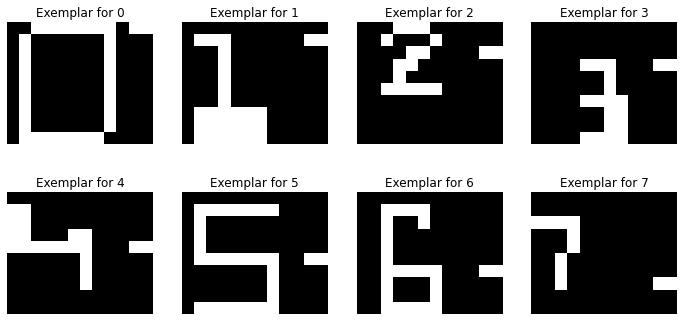

In [79]:
plt.figure(1, figsize=(12,12))

for i in range(len(exemplars)):
    exemplar = exemplars[i].reshape(10, 12)
    plt.subplot(4, 4, i+1)
    plt.imshow(exemplar, cmap='gray')
    plt.title(f'Exemplar for {i}')
    plt.axis('off')

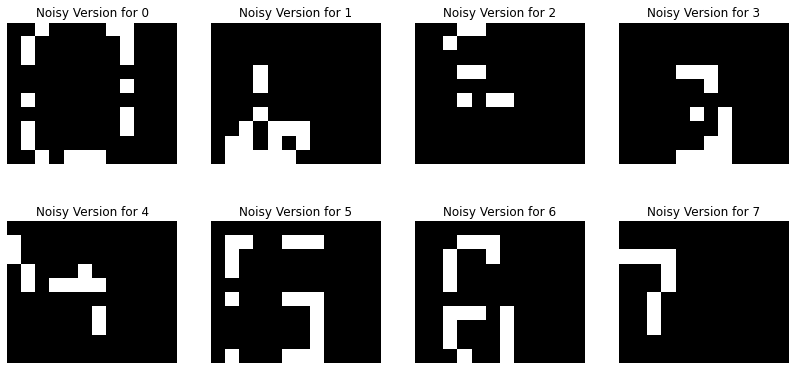

In [86]:
noisy_data = load_noisy_data(threshold=0.60)

plt.figure(1, figsize=(14,14))
for i in range(len(noisy_data)):
    noisy = noisy_data[i].reshape(10, 12)
    plt.subplot(4, 4, i+1)
    plt.title(f'Noisy Version for {i}')
    plt.imshow(noisy, cmap='gray')
    plt.axis('off')

In [87]:
rbm = RestrictedBoltzmannMachine(120, 500)
rbm.train(exemplars, epochs=100)

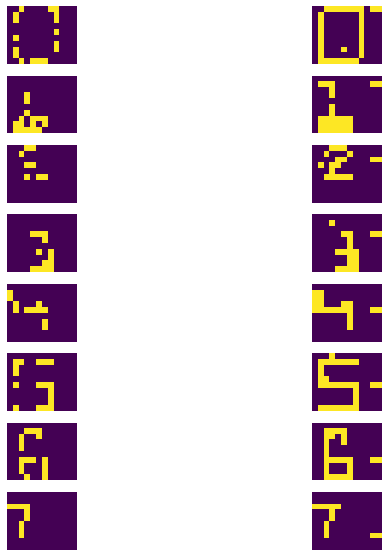

In [88]:
fig, axs = plt.subplots(8, 2, figsize=(10, 10))
for i in range(8):
    axs[i, 0].imshow(noisy_data[i].reshape(10, 12))
    axs[i, 0].axis('off')
    axs[i, 1].imshow(rbm.reconstruct(noisy_data[i], iters=10).reshape(10, 12))
    axs[i, 1].axis('off');
